In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import pathlib

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
SEED = 19011997
SPLIT_VAL = 0.2
SPLIT_TEST = 0.06
BATCH_SIZE = 32
IMG_SIZE = (256,256)

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.5, fill_mode='constant') # oppure "nearest"
    ]
)

In [5]:
path_dataset_training = pathlib.Path('./dataset/split/training')
path_dataset_validation = pathlib.Path('./dataset/split/validation')
path_dataset_testing = pathlib.Path('./dataset/split/testing')

class_names = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

def import_from_directory(dataset_dir):
    return tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=SEED,
        image_size=IMG_SIZE
    )

dataset_training = import_from_directory(path_dataset_training)
dataset_validation = import_from_directory(path_dataset_validation)
dataset_testing = import_from_directory(path_dataset_testing)

dataset_testing = dataset_testing.prefetch(buffer_size=64)
dataset_training = dataset_training.prefetch(buffer_size=64)
dataset_validation = dataset_validation.prefetch(buffer_size=64)

Found 13829 files belonging to 14 classes.
Found 3545 files belonging to 14 classes.
Found 354 files belonging to 14 classes.


In [6]:
images_count = {}
for name in class_names:
    count = len(list(path_dataset_training.glob('{}/*.jpg'.format(name))))
    images_count[name] = count

max_class = max(images_count.values())
class_weights = {}
i = 0
for name in class_names:
    class_weights[i] = max_class / images_count[name]
    i += 1
print(class_weights)

{0: 6.041388518024032, 1: 12.891737891737892, 2: 10.011061946902656, 3: 4.84994640943194, 4: 3.986784140969163, 5: 3.2933042212518195, 6: 6.00929614873838, 7: 7.6825127334465195, 8: 8.333333333333334, 9: 23.567708333333332, 10: 3.5296411856474257, 11: 10.30751708428246, 12: 8.837890625, 13: 1.0}


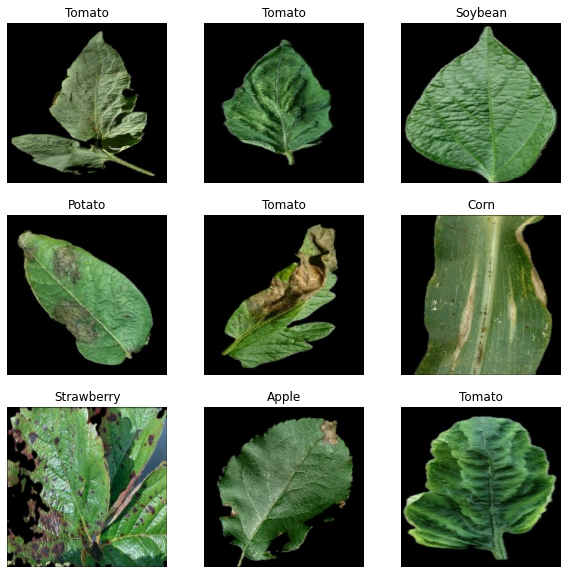

In [7]:
image_batch, label_batch = next(iter(dataset_training))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    index = np.argmax(np.array(label_batch[i]), axis=0)
    plt.title(class_names[index])
    plt.axis("off")

In [8]:
def make_base(input_Shape, trainable=False):
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        input_shape=input_Shape,
        include_top=False
    )

    base_model.trainable = trainable

    return base_model

def make_model(input_shape, num_classes, trainable=False):
    base_model = make_base(input_shape, trainable)
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = tf.keras.layers.Rescaling(1./255)(x)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    x = tf.keras.layers.Dense(num_classes*2, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.125)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    return tf.keras.Model(inputs, outputs)

model = make_model(IMG_SIZE + (3,), len(class_names))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 14)                28686     
Total params: 20,890,166
Trainable params: 28,686
Non-trainable params: 20,861,480
____________________________________________

In [9]:
epochs = 24

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("./checkpoints/best", save_best_only=True),
]

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)

model.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/24
433/433 [==============================] - 66s 134ms/step - loss: 3.7210 - accuracy: 0.7872 - mse: 0.0256 - val_loss: 0.4101 - val_accuracy: 0.9013 - val_mse: 0.0128
Epoch 2/24
433/433 [==============================] - 56s 129ms/step - loss: 1.6953 - accuracy: 0.8878 - mse: 0.0131 - val_loss: 0.3155 - val_accuracy: 0.9089 - val_mse: 0.0103
Epoch 3/24
433/433 [==============================] - 53s 122ms/step - loss: 1.2794 - accuracy: 0.9104 - mse: 0.0103 - val_loss: 0.2610 - val_accuracy: 0.9281 - val_mse: 0.0085
Epoch 4/24
433/433 [==============================] - 57s 132ms/step - loss: 1.0951 - accuracy: 0.9209 - mse: 0.0090 - val_loss: 0.2157 - val_accuracy: 0.9416 - val_mse: 0.0070
Epoch 5/24
433/433 [==============================] - 57s 132ms/step - loss: 0.9232 - accuracy: 0.9314 - mse: 0.0079 - val_loss: 0.2097 - val_accuracy: 0.9379 - val_mse: 0.0070
Epoch 6/24
433/433 [==============================] - 57s 132ms/step - loss: 0.8434 - accuracy: 0.9358 - mse: 0.007

In [10]:
#model.save_weights('./models/xception-w.h5')

In [9]:
finemodel = make_model(IMG_SIZE + (3,), len(class_names), True)
finemodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 512)         0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1436

In [10]:
finemodel.load_weights('./models/xception-w.h5')

finemodel.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", "mse"],
)

finemodel.fit(
    dataset_training,
    validation_data=dataset_validation,
    epochs=8,
    class_weight=class_weights
)

Epoch 1/8
433/433 [==============================] - 143s 303ms/step - loss: 0.7180 - accuracy: 0.9397 - mse: 0.0065 - val_loss: 0.1834 - val_accuracy: 0.9354 - val_mse: 0.0068
Epoch 2/8
433/433 [==============================] - 126s 290ms/step - loss: 0.3560 - accuracy: 0.9654 - mse: 0.0038 - val_loss: 0.1443 - val_accuracy: 0.9518 - val_mse: 0.0050
Epoch 3/8
433/433 [==============================] - 124s 285ms/step - loss: 0.2535 - accuracy: 0.9756 - mse: 0.0027 - val_loss: 0.1385 - val_accuracy: 0.9529 - val_mse: 0.0048
Epoch 4/8
433/433 [==============================] - 121s 279ms/step - loss: 0.2355 - accuracy: 0.9789 - mse: 0.0024 - val_loss: 0.1283 - val_accuracy: 0.9594 - val_mse: 0.0044
Epoch 5/8
433/433 [==============================] - 119s 274ms/step - loss: 0.1687 - accuracy: 0.9834 - mse: 0.0018 - val_loss: 0.1244 - val_accuracy: 0.9628 - val_mse: 0.0042
Epoch 6/8
433/433 [==============================] - 124s 287ms/step - loss: 0.1332 - accuracy: 0.9849 - mse: 0.001

In [12]:
finemodel.save('./models/vgg16-fine')

INFO:tensorflow:Assets written to: ./models/vgg16-fine\assets


In [13]:
testmodel = tf.keras.models.load_model('./models/vgg16-fine')
testmodel.evaluate(dataset_testing)

12/12 [==============================] - 3s 137ms/step - loss: 0.0275 - accuracy: 0.9859 - mse: 0.0012


[0.027521895244717598, 0.9858757257461548, 0.0012148699024692178]